In [ ]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import os

def run():
    path = Path.cwd()
    while len(path.name) and path.name != 'codes':
        path = path.parent

    if len(path.name):
        os.chdir(path)
    else:
        raise ValueError('Cannot find the root directory of the project.')

run()
from pathlib import Path
from importlib import reload
from agents import Agent
from tasks import akam_tasks as ts
import config as co
from utils import *  # get_current_file_name, goto_root_dir
import pprint
import joblib
from path_settings import *
import CustomMapper.CustomMapper as c
import torch
import pickle
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from agents.DynamicSystems import ISNNet
from agents.ComplexAgent import DynamicAgent
import copy


reload(ts)
pp = pprint.PrettyPrinter(indent=4, depth = 4)
goto_root_dir.run()

2025-09-12 10:16:44.560185: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-12 10:16:44.648030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-12 10:16:44.692244: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-12 10:16:44.692516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-12 10:16:44.754877: I tensorflow/core/platform/cpu_feature_gua

# This is the structured Notebook to look at. 

We test the various types of models to various types of data. 

Specifically we constrain to 1 task and 4 cognitive models: 
task: 
- PRL (walk) : reward probability of each action given a stimulus follows a random walk. 

Cognitive models:
- "MB0s", "LS0", "MB0", "MB1"

## Step 1: simulate and store the data


In [2]:
agent = "MB0s"
try: 
    experiment = pickle.load(open(DATA_PATH/f"experiment_{agent}_1.pkl", "rb"))
    experiment.initialise_dataloaders()
    experiment.configs["model_specs"]["model_params"]["batch_size"] = 64
    experiment.initialise_trainer(experiment.configs)
except FileNotFoundError:
    print(f"Experiment for {agent} not found. Please run the simulation first.")
    tasks = {
        # "PRL": ts.Two_step(com_prob=1),  # common transition always happens
        # "RTS": ts.Two_step(),
        # "NTS": ts.Two_step(rew_gen="trans_rev"),
        "walk": ts.Two_step(rew_gen="walks"),
    }
    N_blocks = 1000
    N_trials = 100
    device = "cpu"
    exp_folder = 0  #automatically generate this
    seed = 0
    # For now only consider RTS
    agents = {}
    config = {}
    cog_types = ["MB0s", "LS0", "MB0", "MB1"]

    for cog_type in cog_types:
        cog_config = co.sim_config_from_inputs(False, 
                                            agent_type="RTSCog", 
                                            cog_type=cog_type, 
                                            device=device, 
                                            seed=seed,
                                            num_blocks=N_blocks,
                                            num_trials=N_trials,
                                            exp_folder=0)
        config[f'walks_{cog_type}'] = cog_config
        agents[f'walks_{cog_type}'] = Agent(cog_config['agent_type'], config = cog_config)

    for cog_type in cog_types: 
        agents[f'walks_{cog_type}'].simulate(tasks["walk"], config[f'walks_{cog_type}'], save = True)
        
    # Trainer parameters
    batch_size = 20
    RTRNN_config = {
        "task": "PRL_Bartolo", 
        "dt": 0.02, # 0.02s time step, as in Jaffe et al. 
        "T": 200, # 1s upper for RT
        "n_blocks": 800,
        "cog_data": SIM_SAVE_PATH / 'simulated_Akam_RTS' / 'LS0_seed0.pkl',
        "bias": 0.01, 
        "ndt_s": 0.01, 
        "ndt_mu": 0.1, 
        "driftscale": 2, 
        "redo_choices": False,
        "trainer_type": "RTRNNTrainer",
        "model_specs": {
            "model_name": "RTRNN", 
            "model_path": "Network_models.RTRNN",
            "model_params":{
                "batch_size": batch_size, "input_size": 6, "output_size": 2, "hidden_size": 16, "recurrence_per_trial": 2,
                "cell_type":"GRU", "trial_output_hidden": 0, "trial_output_hidden_size": [], # if want hidden output layers (deep output, then give a list)
                "trial_output_hidden_nonlinearities": [], "pad_zeros":0, "last_step": False
            },
        },
        "rt_weight": 0.01,
        "device": "cuda", 
        "scheduler": {
            "name": "ReduceLROnPlateau",
            "params": {
                "mode": "min",
                "factor": 0.1,
                "patience": 100,
                "min_lr": 5e-4,
                "cooldown": 50, 
            },
        }, 
        "optimizer_specs":{
            "optimizer_name": "Adam",
            "optimizer_params": {
                "lr": 0.0005,
            },
        },
        "training_config":{
            "task_id": "1.1",
            "task_config": {
                "task": "PRL_Bartolo",
            }
        },  
        "save_path": MODEL_SAVE_PATH ,
        "check_path": MODEL_SAVE_PATH,
        "log_path": LOG_PATH, # These are to be modified when the big configs gets defined
    }

    for agent in ["MB0s", "LS0", "MB0", "MB1"]:
        RTRNN_config["cog_data"] = SIM_SAVE_PATH / 'simulated_Akam_RTS' / f'{agent}_seed0.pkl'
        experiment = c.CustomMapper(RTRNN_config)
        experiment.rt_model = "RELOAD"
        pickle.dump(experiment, open(DATA_PATH/f"experiment_{agent}_1.pkl", "wb"))

## Grab the dataset

In [3]:
dataloaders = None

In [4]:
if dataloaders is None:
    dataloaders = experiment.dataloaders
    del experiment

print(f"Loaded dataloaders for {agent} agent.")

Loaded dataloaders for MB0s agent.


In [5]:
from Network_models.HMMModels import HMMModel_linearK
from CustomMapper.CustomMapper import PaddedRTSeriesDataset

(array([11390.,     0.,     0.,     0.,     0., 15072., 36311.,  9485.,
         4800.,  2942.]),
 array([-1.00000000e+00, -8.00001241e-01, -6.00002481e-01, -4.00003722e-01,
        -2.00004963e-01, -6.20344964e-06,  1.99992556e-01,  3.99991315e-01,
         5.99990074e-01,  7.99988834e-01,  9.99987593e-01]),
 <BarContainer object of 10 artists>)

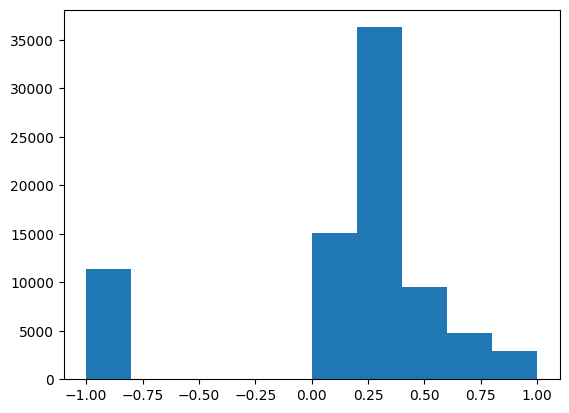

In [6]:
plt.hist(dataloaders["train"].dataset.x[:, :, 1].flatten().cpu().numpy())

In [7]:
x = copy.deepcopy(dataloaders["train"].dataset.x)

dt = 0.5
x[:, :, 1] = x[:, :, 1] * 1.5 * (x[:, :, 1] > 0) + x[:, :, 1] * (-1.5) * (x[:, :, 1] < 0)
hmm_data = PaddedRTSeriesDataset(
    u=dataloaders["train"].dataset.u[0:100], 
    x=x[0:100],
    dt=dt,
    rt_ceiling=1.5,
    keep_onehot=True,
)
hmm_loader = torch.utils.data.DataLoader(
    hmm_data,
    batch_size=16,
    shuffle=True,
)
x_val = copy.deepcopy(dataloaders["val"].dataset.x)
x_val[:, :, 1] = x_val[:, :, 1] * 1.5 * (x_val[:, :, 1] > 0) + x_val[:, :, 1] * (-1.5) * (x_val[:, :, 1] < 0)
hmm_data_val = PaddedRTSeriesDataset(
    u=dataloaders["val"].dataset.u,
    x=x_val,
    dt=dt,
    rt_ceiling=1.5,
    keep_onehot=True,
)
hmm_loader_val = torch.utils.data.DataLoader(
    hmm_data_val,
    batch_size=200,
    shuffle=False,
)

(array([   42., 15528., 25481., 10403.,  5727.,  3706.,  2669.,  2122.,
         1653., 12669.]),
 array([0.00253304, 0.15227974, 0.30202644, 0.45177313, 0.60151983,
        0.75126652, 0.90101322, 1.05075991, 1.20050661, 1.3502533 ,
        1.5       ]),
 <BarContainer object of 10 artists>)

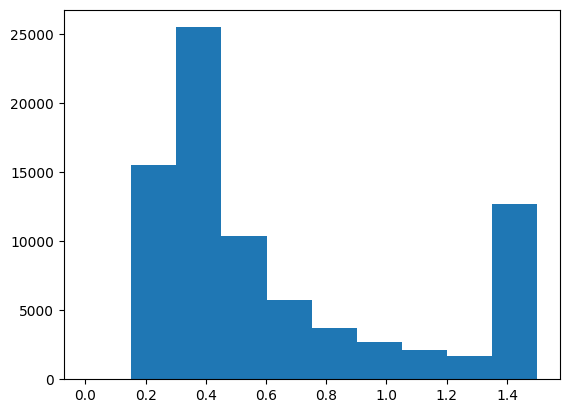

In [8]:
plt.hist(x[:, :, 1].cpu().numpy().flatten())

In [ ]:
from Network_models.HMMModels import HMMModel_linearK
K = 8
stim_bits = 3
model = HMMModel_linearK(z_dim = K, stim_types=stim_bits, symmetric=True)
# model.load_checkpoint(MODEL_SAVE_PATH / "HMMModel_linearK" / "best_epoch_no_rt.pth")
model.get_params()
model.to("cuda")
ll_seq = []
epochs = 16
best_ll = -np.inf
model.train()
for epoch in range(epochs): 
    ll_loc = torch.zeros(len(hmm_loader))

    for i, train_set in enumerate(hmm_loader):
        recording = train_set["recording"].to("cuda")
        stim_type = train_set["stimulus_type"].to("cuda")
        mask = train_set["mask"].to("cuda")
        
        ll = model.fit_batch(stim_type, recording, mask.long())
        print(f"train_set {i+1}/{len(hmm_loader)}, log-lik={ll.mean().item():.3f}")
        if ll.mean().item() > best_ll: 
            best_ll = ll.mean().item()
            model.save_checkpoint(MODEL_SAVE_PATH / "HMMModel_linearK" / f"best_epoch.pth")
 
        ll_loc[i] = ll.mean().item()
    ll_seq.append(ll_loc.mean().item())
   
    # K_seq.append(model.K[0].cpu().detach().numpy())
    # P_seq.append(model.P.cpu().detach().numpy())
    # pi_seq.append(model.pi.cpu().detach().numpy())
    print(f"Epoch {epoch+1}/{epochs}, log-lik={ll_loc.mean().item():.3f}")
model.eval() 

[autoreload of Network_models.HMMModels failed: Traceback (most recent call last):
  File "/home/timmy/miniconda3/envs/test/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/timmy/miniconda3/envs/test/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/timmy/miniconda3/envs/test/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/timmy/miniconda3/envs/test/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/timmy/miniconda3/envs/test/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/timmy/miniconda3/envs/test/lib/python3.12/site-packages

HMMModel_linearK()

In [230]:
model.load_checkpoint(MODEL_SAVE_PATH / "HMMModel_linearK" / "best_epoch.pth")

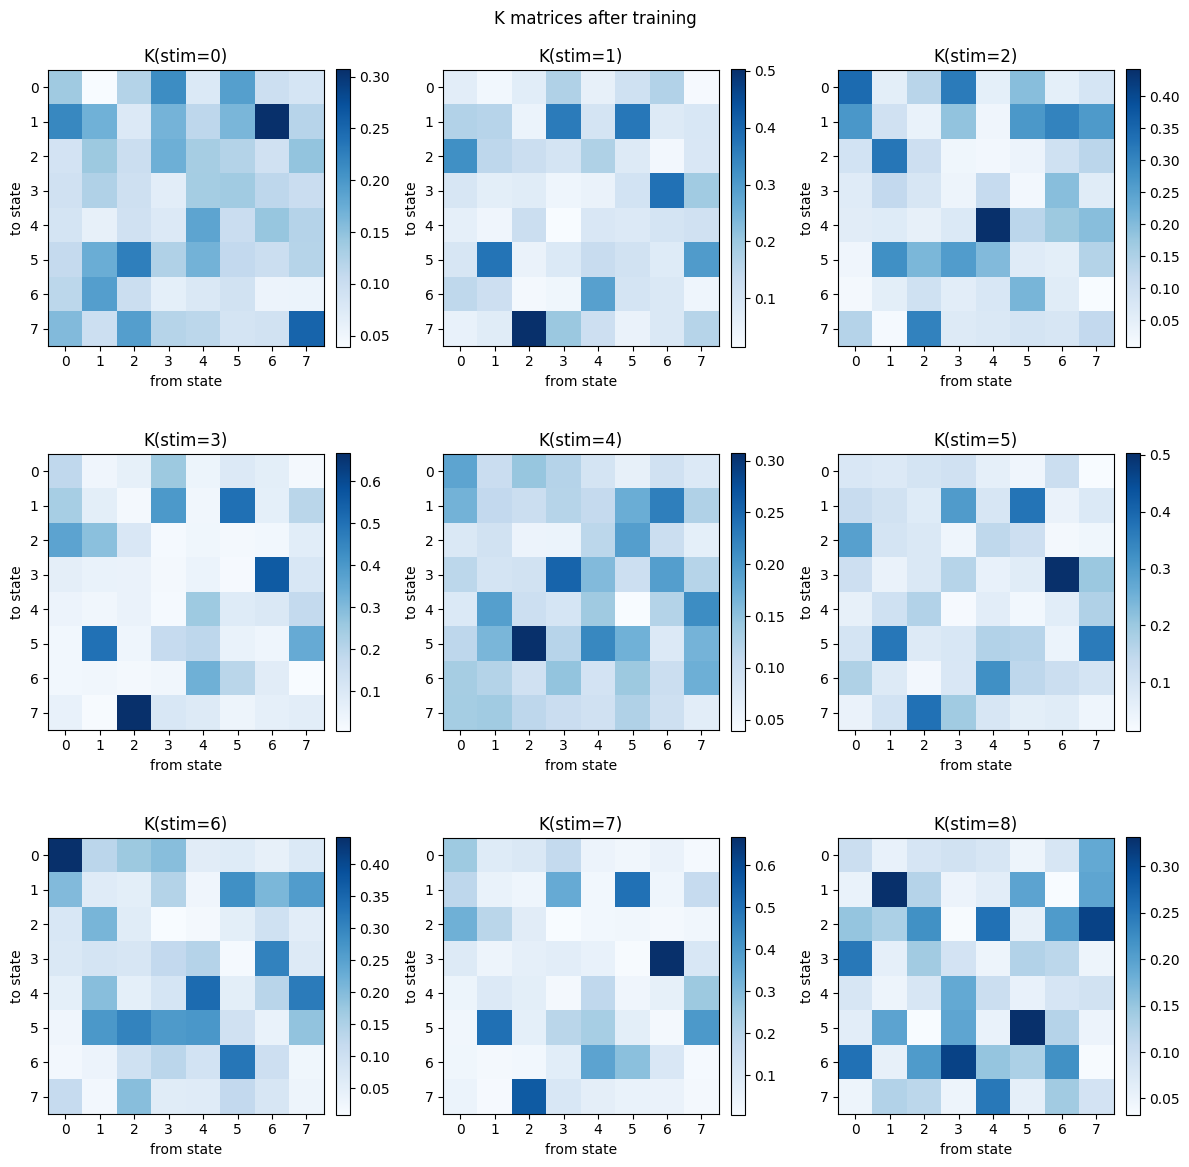

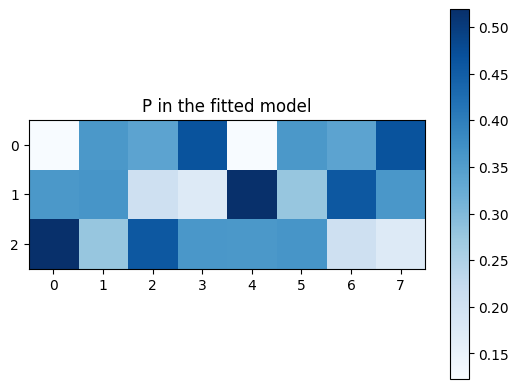

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for stim in range(9):
    ax = axes[stim // 3, stim % 3]
    im = ax.imshow(model.K[stim].cpu().detach(), cmap="Blues", origin="upper")
    ax.set_title(f"K(stim={stim})")
    ax.set_xlabel("from state")
    ax.set_ylabel("to state")
    ax.set_xticks(range(model.K.shape[2]))
    ax.set_yticks(range(model.K.shape[1]))
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.suptitle("K matrices after training")
plt.tight_layout()
plt.show()
plt.imshow(model.P.T.cpu().detach(), cmap="Blues", origin="upper")
plt.title("P in the fitted model"); plt.colorbar(); plt.show()



In [115]:
with torch.no_grad():
    lalpha = model.predictive_forward(stim_type, recording, mask.long())
lalpha_ = lalpha - lalpha.min(dim=-1, keepdim=True).values
alpha = torch.exp(lalpha_)
alpha = alpha / alpha.sum(dim=-1, keepdim=True)
expected_choice = (alpha @ model.P) @ torch.tensor([0, -1, 1], device = alpha.device).float()

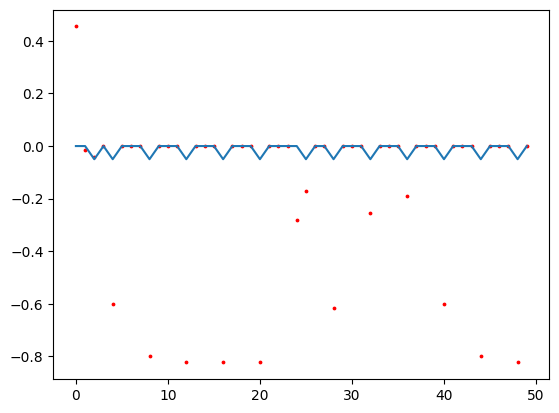

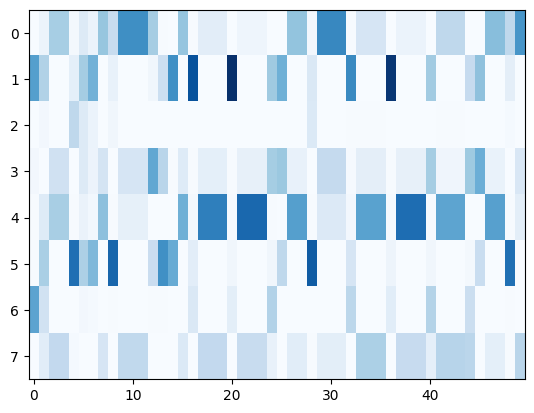

In [55]:
index = 8
plotted= 50
plt.plot(0.1 * (recording - 1.5 * (recording != 0))[index, :plotted].cpu().detach().numpy(), label = "recording")
x = torch.arange(0, recording.shape[1])[:plotted]
plt.scatter(x, expected_choice[index, :plotted].cpu().detach().numpy(), label = "pred", color = "red", s = 3)
plt.show()
plt.imshow(alpha[1][:plotted, :].T.cpu().detach().numpy(), aspect='auto', cmap='Blues', interpolation="nearest")
plt.show()

In [9]:
from Network_models.HMMModels import HMMModel_linearK, HMMModel_symmetric
K = 8
stim_bits = 3
loss = "BCE"
optimizer = "adam"
lr = 1e-1

# model = HMMModel_linearK(z_dim = K, stim_types=stim_bits, symmetric=True)
model = HMMModel_symmetric(z_dim = K, stim_types=stim_bits, reward_bit=1, state_bit=0, model_type="perstate")
# model.load_checkpoint(MODEL_SAVE_PATH / "HMMModel_linearK" / "100_trials_dt05_8states_run2.pth")
model.get_params()

model = model.to("cuda")

optim = torch.optim.Adam(model.parameters(), lr=lr) 
device = next(model.parameters()).device          # cuda:0
for state in optim.state.values():
    for k, v in state.items():
        if torch.is_tensor(v):
            state[k] = v.to(device)
ll_seq = []
epochs = 20
best_ll = -np.inf
model.train()
for epoch in range(epochs): 
    ll_loc = torch.zeros(len(hmm_loader))

    for i, train_set in enumerate(hmm_loader):
        recording = train_set["recording"].to("cuda")
        stim_type = train_set["stimulus_type"].to("cuda")
        mask = train_set["mask"].to("cuda")
        
        ll = model.fit_bptt(stim_type, recording, mask.long(), optim, loss = loss)
        print(f"train_set {i+1}/{len(hmm_loader)}, loss={ll.mean().item():.3f}")
        if ll.mean().item() > best_ll: 
            best_ll = ll.mean().item()
            model.save_checkpoint(MODEL_SAVE_PATH / "HMMModel_linearK" / f"best_epoch_bptt.pth")
 
        ll_loc[i] = ll.mean().item()
    ll_seq.append(ll_loc.mean().item())
   
    # K_seq.append(model.K[0].cpu().detach().numpy())
    # P_seq.append(model.P.cpu().detach().numpy())
    # pi_seq.append(model.pi.cpu().detach().numpy())
    print(f"Epoch {epoch+1}/{epochs}, log-lik={ll_loc.mean().item():.3f}")
    for i, val_set in enumerate(hmm_loader_val):
        recording = val_set["recording"].to("cuda")
        stim_type = val_set["stimulus_type"].to("cuda")
        mask = val_set["mask"].to("cuda")
        ll = model.fit_bptt(stim_type, recording, mask.long(), optim, loss = loss, val = True)
        print(f"val_set {i+1}/{len(hmm_loader_val)}, loss={ll.mean().item():.3f}")
        
model.eval() 

train_set 1/7, loss=0.691
train_set 2/7, loss=0.636
train_set 3/7, loss=0.586
train_set 4/7, loss=0.541
train_set 5/7, loss=0.500
train_set 6/7, loss=0.464
train_set 7/7, loss=0.421
Epoch 1/20, log-lik=0.548
val_set 1/1, loss=0.401
train_set 1/7, loss=0.402
train_set 2/7, loss=0.383
train_set 3/7, loss=0.362
train_set 4/7, loss=0.342
train_set 5/7, loss=0.326
train_set 6/7, loss=0.307
train_set 7/7, loss=0.305
Epoch 2/20, log-lik=0.347
val_set 1/1, loss=0.282
train_set 1/7, loss=0.291
train_set 2/7, loss=0.276
train_set 3/7, loss=0.262
train_set 4/7, loss=0.257
train_set 5/7, loss=0.249
train_set 6/7, loss=0.252
train_set 7/7, loss=0.251
Epoch 3/20, log-lik=0.263
val_set 1/1, loss=0.231
train_set 1/7, loss=0.241
train_set 2/7, loss=0.235
train_set 3/7, loss=0.227
train_set 4/7, loss=0.237
train_set 5/7, loss=0.219
train_set 6/7, loss=0.221
train_set 7/7, loss=0.232
Epoch 4/20, log-lik=0.230
val_set 1/1, loss=0.214
train_set 1/7, loss=0.222
train_set 2/7, loss=0.224
train_set 3/7, loss=

HMMModel_symmetric()

In [37]:
model.S

8

In [137]:
for name, p in model.named_parameters():
    if p.grad is not None:
        print(f"{name:20} param on {p.device}  exp_avg on {optim.state[p]['exp_avg'].device}")
        print(f"grad on {p.grad.device}  exp_avg_sq on {optim.state[p]['exp_avg_sq'].device}")

logK_stim            param on cuda:0  exp_avg on cuda:0
grad on cpu  exp_avg_sq on cuda:0
logK_grounding       param on cuda:0  exp_avg on cuda:0
grad on cpu  exp_avg_sq on cuda:0
logP                 param on cuda:0  exp_avg on cuda:0
grad on cpu  exp_avg_sq on cuda:0
logpi                param on cuda:0  exp_avg on cuda:0
grad on cpu  exp_avg_sq on cuda:0


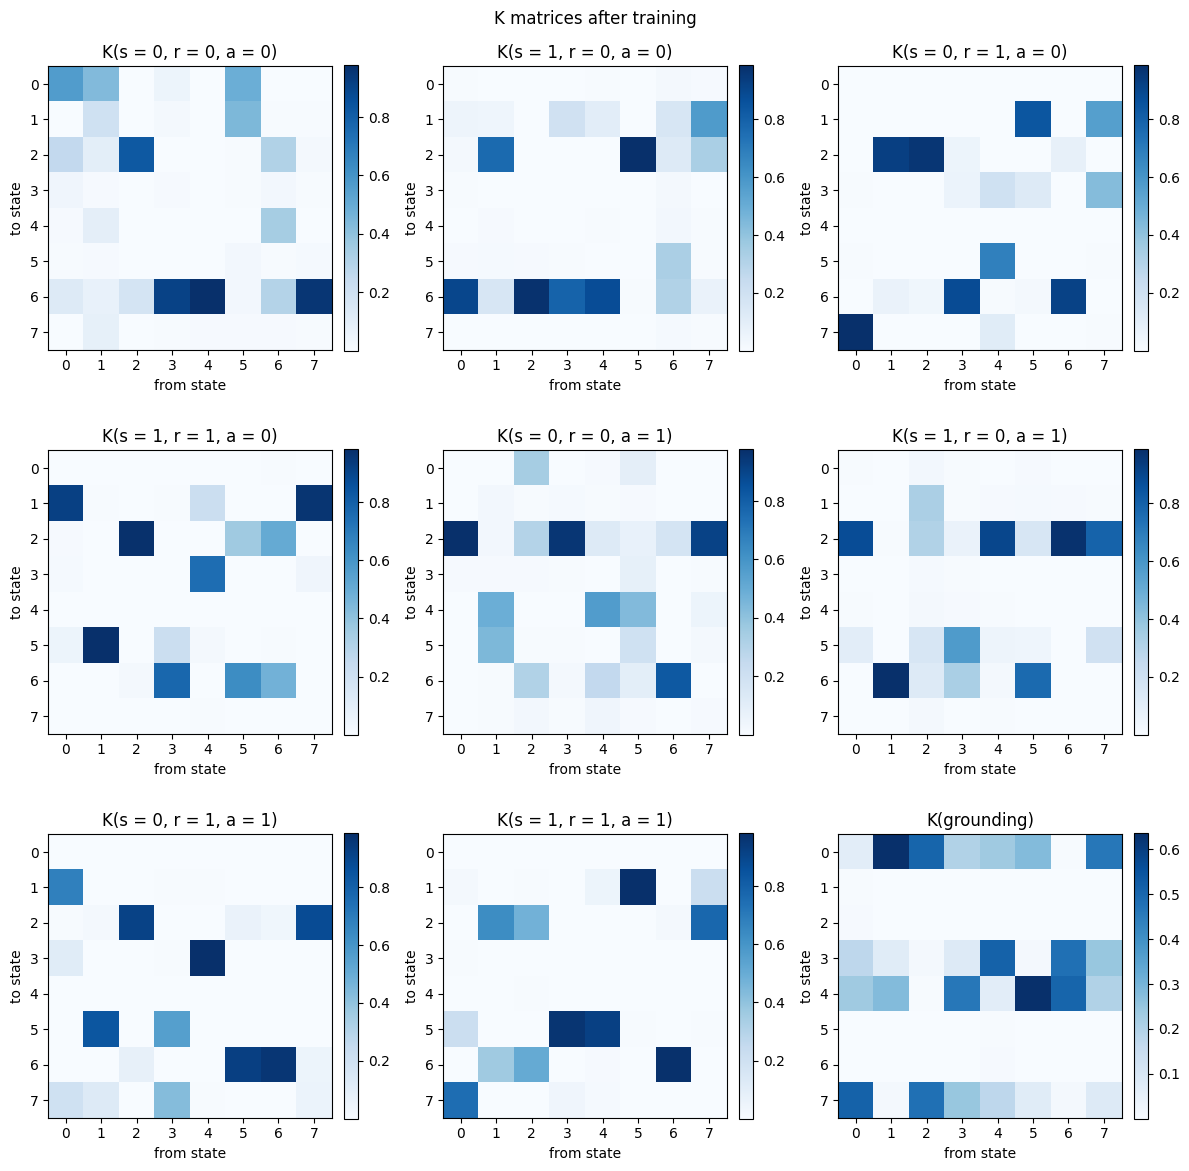

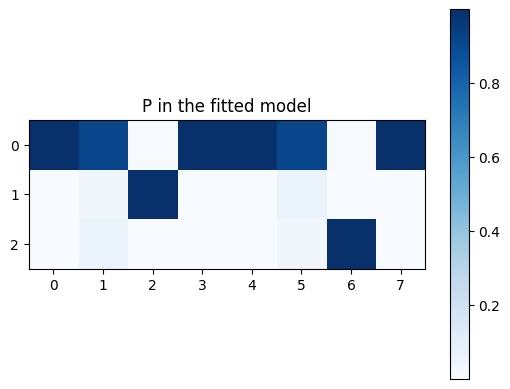

In [11]:
from itertools import product
stim_bits = torch.tensor(list(product([0,1], repeat=3)),
                        dtype=torch.float32, device="cuda")   # (S,stim_types)


fig, axes = plt.subplots(3, 3, figsize=(12, 12))
# order = [2, 3, 7, 9, 11, 13, 15, 1, 4, 6, 8, 10, 12, 14, 5, 0]
# order = [0, 2, 3, 1, 4, 6, 7, 5]
order = [0, 1, 2, 3, 4, 5, 6, 7]
reorder = True

for stim in range(9):
    ax = axes[stim // 3, stim % 3]
    K = model.K[stim].cpu().detach().numpy()
    if reorder:
        K = K[np.ix_(order, order)]
    im = ax.imshow(K, cmap="Blues", origin="upper")
    s = stim_bits[stim].cpu().detach().int().numpy() if stim < 8 else "grounding"
    if stim < 8: 
        ax.set_title(f"K(s = {s[-1]}, r = {s[1]}, a = {s[0]})") 
    else: 
        ax.set_title(f"K(grounding)")
    ax.set_xlabel("from state")
    ax.set_ylabel("to state")
    ax.set_xticks(range(len(order)))
    ax.set_yticks(range(len(order)))
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.suptitle("K matrices after training")
plt.tight_layout()
plt.show()

P = model.P.cpu().detach().numpy()
if reorder:
    P = P[order, :]
plt.imshow(P.T, cmap="Blues", origin="upper")
plt.title("P in the fitted model")
plt.colorbar()
plt.show()



In [18]:
import networkx as nx
from itertools import product

def plot_markov_networks(model,
                         order=None,           # permutation of state indices for consistent node order
                         topk=3,               # draw top-k outgoing edges per node
                         edge_thresh=0.02,     # minimum edge prob to draw
                         ds_tau=0.55,          # direction-selective threshold on max(P_L, P_R)
                         nd_tau=0.50,          # treat as non-directional if ND prob >= nd_tau
                         node_size=500,
                         with_labels=True):
    """
    Visualize K(s): directed graph per stimulus context + grounding.
    Nodes colored by direction selectivity inferred from P:
      - color ~ (P_right - P_left) using a diverging colormap
      - non-directional (ND-dominant or weak) nodes are grey
    """
    device = next(model.parameters()).device if len(list(model.parameters())) else torch.device("cpu")
    # Pull params
    K_bank = model.K.detach().cpu().numpy()   # (S+1, K_to, K_from)
    P      = model.P.detach().cpu().numpy()   # (K, 3)
    K = P.shape[0]                             # num states
    S = K_bank.shape[0] - 1                   # num real contexts

    # Build stimulus bit labels (only used for titles)
    stim_bits = torch.tensor(list(product([0,1], repeat=int(np.log2(S)))), dtype=torch.int64)
    # Default state order
    if order is None:
        order = list(range(K))
    order = list(order)

    # Reorder P for node coloring
    P_ord = P[order, :]
    pND, pL, pR = P_ord[:, 0], P_ord[:, 1], P_ord[:, 2]
    pref = pR - pL                          # right minus left preference in [-1,1]
    sel  = np.maximum(pL, pR)               # direction selectivity strength
    is_nd = pND >= nd_tau
    is_ds = (sel >= ds_tau) & (~is_nd)      # mark DS only if directional and not ND-dominant

    # Map preferences to colors
    cmap = plt.cm.coolwarm
    norm = plt.Normalize(vmin=-1.0, vmax=1.0)
    node_colors = []
    for i in range(K):
        if is_ds[i]:
            node_colors.append(cmap(norm(pref[i])))
        else:
            node_colors.append((0.7, 0.7, 0.7, 1.0))  # grey

    # Fixed positions for all subplots
    nodes_seq = list(range(K))             # use ordered indices positions, but label by order later if needed
    pos = nx.circular_layout(nodes_seq)    # deterministic, consistent across panels

    # Precompute consistent axis limits for all subplots
    xs = np.array([p[0] for p in pos.values()])
    ys = np.array([p[1] for p in pos.values()])
    xpad = (xs.max() - xs.min()) * 0.15 + 1e-3
    ypad = (ys.max() - ys.min()) * 0.15 + 1e-3
    xlim = (xs.min() - xpad, xs.max() + xpad)
    ylim = (ys.min() - ypad, ys.max() + ypad)

    # Grid: contexts + grounding
    n_rows, n_cols = 3, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axes = np.asarray(axes).reshape(n_rows, n_cols)

    for stim in range(S + 1):
        r, c = divmod(stim, n_cols)
        ax = axes[r, c]
        G = nx.DiGraph()

        # Add nodes with colors (use reindexed labels to reflect 'order')
        labels = {i: str(order[i]) for i in range(K)} if with_labels else None
        G.add_nodes_from(nodes_seq)

        # Get K matrix for this context (or grounding)
        K_mat = K_bank[stim if stim < S else -1].copy()  # (K_to, K_from)
        # Reorder states
        K_mat = K_mat[np.ix_(order, order)]

        # Add top-k edges per "from" (columns are 'from', rows are 'to')
        widths = []
        edges = []
        for j in range(K):  # from
            col = K_mat[:, j]
            idx = np.argsort(col)[::-1][:topk]
            for i in idx:   # to
                w = float(col[i])
                if w < edge_thresh:
                    continue
                edges.append((j, i, w))  # note: using reordered indices
                widths.append(1.0 + 2.0 * w)

        G.add_weighted_edges_from(edges)

        # Draw
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_size, ax=ax)
        nx.draw_networkx_edges(G, pos, width=widths if widths else 1.0, arrows=True, arrowstyle='-|>', arrowsize=10, alpha=0.9, ax=ax)
        if with_labels:
            nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, ax=ax)

        # Titles
        if stim < S:
            s = stim_bits[stim].numpy()
            ax.set_title(f"K(s={s[0]}, r={s[1]}, a={s[2]})")
        else:
            ax.set_title("K(grounding)")

        # Consistent axes across panels
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')

    # Empty panels (if any)
    for idx in range(S + 1, n_rows * n_cols):
        r, c = divmod(idx, n_cols)
        axes[r, c].axis('off')

    # Shared colorbar for preference
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), fraction=0.02, pad=0.01)
    cbar.set_label("Right - Left preference (P[R] - P[L])")

    # Legend for non-directional
    # (Optional) can add as a patch if desired

    plt.suptitle("Markov networks per context (nodes colored by direction selectivity)")
    # plt.tight_layout()
    # plt.show()
    return fig



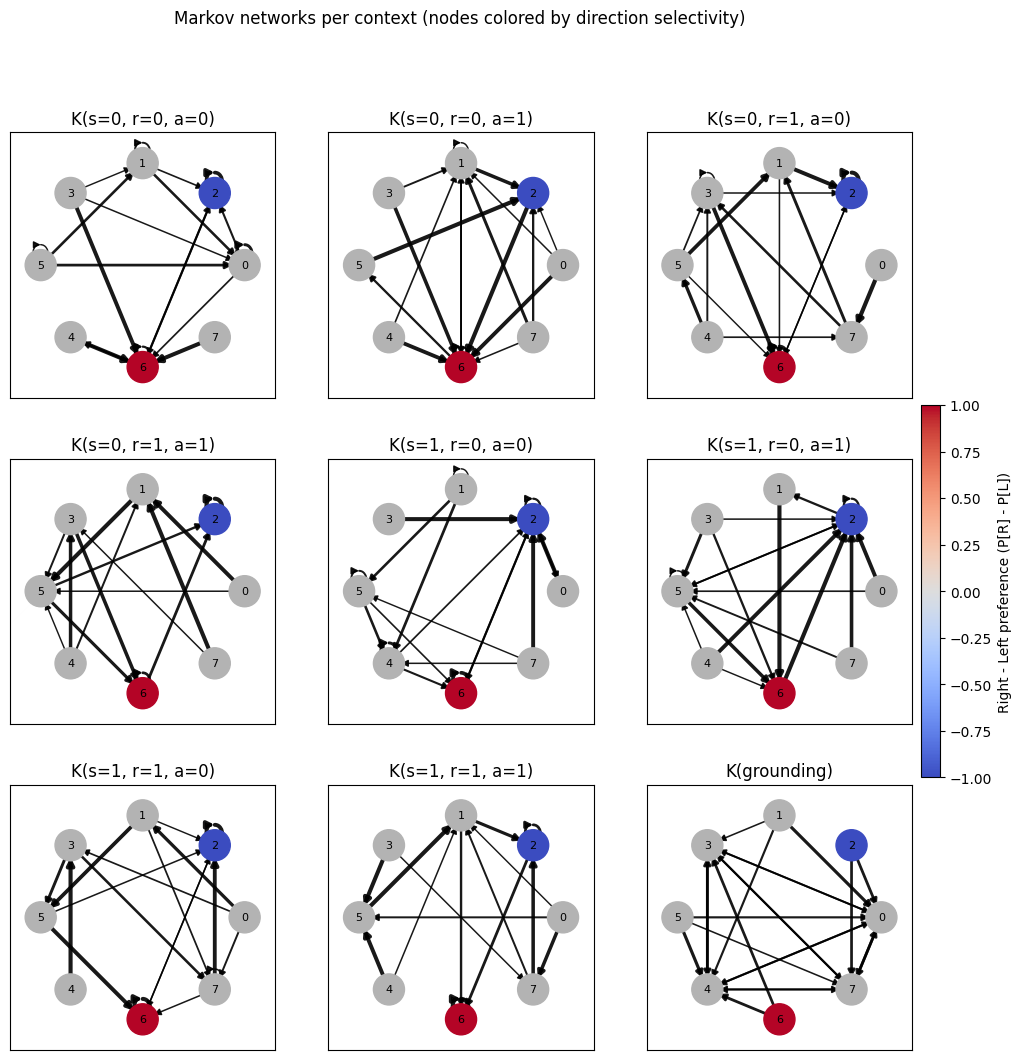

In [19]:
fig = plot_markov_networks(model, order=[0,2,1,3,5,4,6,7])  # example order
fig.savefig(f'../../figures/hmm_vis.png')

In [20]:
val_set = next(iter(hmm_loader_val))
recording = val_set["recording"].to("cuda")
stim_type = val_set["stimulus_type"].to("cuda")
mask = val_set["mask"].to("cuda")
with torch.no_grad():
    lalpha = model.predictive_forward(stim_type, recording, mask.long())
    # lalpha = model.predictive_forward(stim_type, recording, torch.ones_like(mask).long())
lalpha_ = lalpha - lalpha.min(dim=-1, keepdim=True).values
alpha = torch.exp(lalpha_)
alpha = alpha / alpha.sum(dim=-1, keepdim=True)
expected_choice = (alpha @ model.P) @ torch.tensor([0, -1, 1], device = alpha.device).float()

In [61]:
val_set['recording'].shape
val_set["mask"].shape

torch.Size([200, 400])

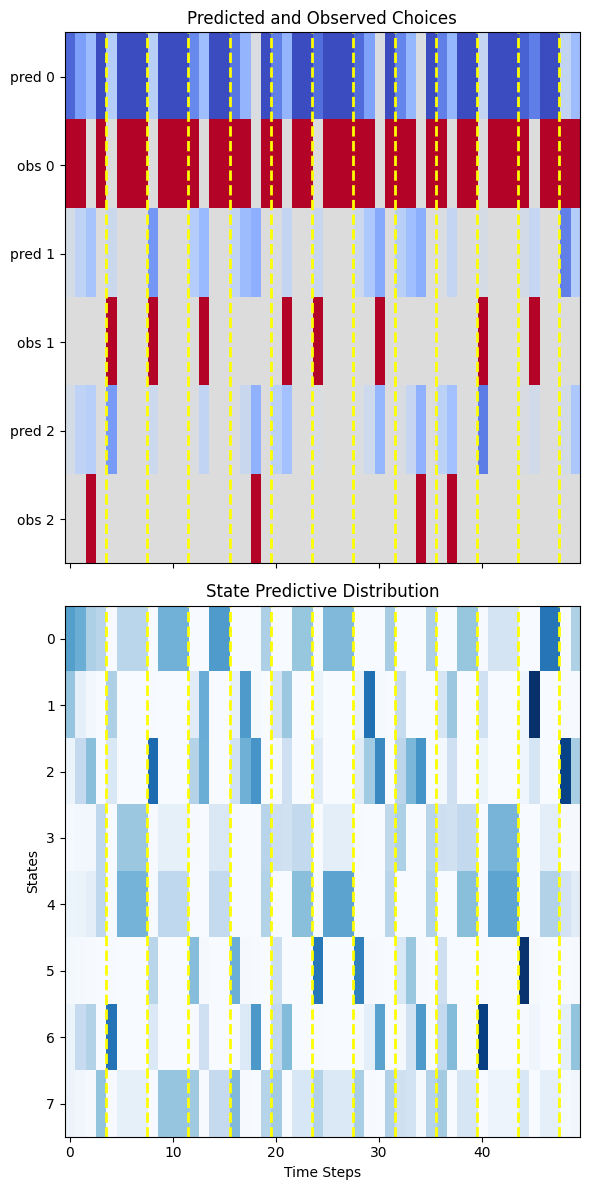

In [ ]:
from matplotlib.colors import ListedColormap

choices = alpha @ model.P
target = torch.zeros_like(choices)
target[..., 0] = (recording[...] == 0).float()
target[..., 1] = (recording[...] == 1).float()
target[..., 2] = (recording[...] == 2).float()

fig, ax = plt.subplots(2, 1, figsize=(6, 12), sharex=True)

index = 0
plotted= 50

# Interleave choices and target along the last dimension
interleaved = torch.empty(choices.shape[:-1] + (choices.shape[-1] + target.shape[-1],), device=choices.device)
interleaved[..., ::2] = choices * -1
interleaved[..., 1::2] = target

to_plot = interleaved[index, :plotted].cpu().detach().numpy().T

ax[0].imshow(to_plot, aspect='auto', cmap="coolwarm", interpolation="nearest")
ax[0].set_yticks(np.arange(to_plot.shape[0]))
ax[0].set_yticklabels([f"pred {i//2}" if i % 2 == 0 else f"obs {i//2}" for i in range(to_plot.shape[0])])
ax[0].set_title("Predicted and Observed Choices")

if reorder: 
    ax[1].imshow(alpha[index][:plotted, order].T.cpu().detach().numpy(), aspect='auto', cmap='Blues', interpolation="nearest")
else:
    ax[1].imshow(alpha[index][:plotted, :].T.cpu().detach().numpy(), aspect='auto', cmap='Blues', interpolation="nearest")
ax[1].set_title("State Predictive Distribution")
ax[1].set_xlabel("Time Steps")
ax[1].set_ylabel("States")

# Draw yellow dashed lines
interval = int(1.5 // dt + 1)
for xpos in range(interval, plotted, interval):
    ax[0].axvline(x=xpos - 0.5, color='yellow', linestyle='--', linewidth=2)
    ax[1].axvline(x=xpos - 0.5, color='yellow', linestyle='--', linewidth=2)

plt.tight_layout()


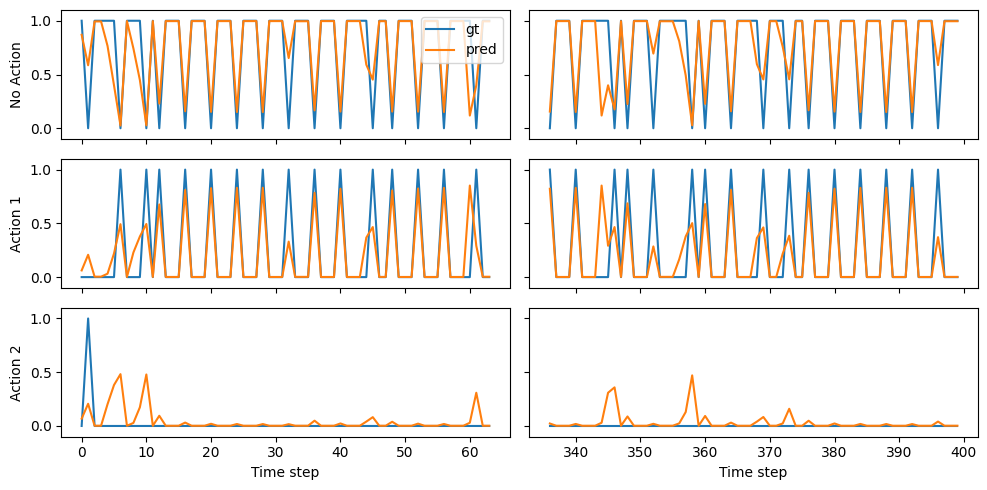

In [41]:
# Compute predictions and one-hot targets (reuse if already defined)
choices = alpha @ model.P                                  # (B,T,3) predicted probs
target = torch.zeros_like(choices)                         # (B,T,3) one-hot ground truth
target[..., 0] = (recording == 0).float()
target[..., 1] = (recording == 1).float()
target[..., 2] = (recording == 2).float()

# Select a sequence index to plot
idx = 12  # change as needed

# Extract arrays to CPU numpy
pred = choices[idx].detach().cpu().numpy()                 # (T,3)
gt   = target[idx].detach().cpu().numpy()                  # (T,3)

T = pred.shape[0]
first_n = min(64, T)
last_n  = min(64, T)
start_last = max(0, T - last_n)

fig, ax = plt.subplots(3, 2, figsize=(10, 5), sharex='col', sharey='row')
ylabs = ['No Action', 'Action 1', 'Action 2']

# First 400 (or fewer) time steps
for i in range(3):
    ax[i, 0].plot(np.arange(first_n), gt[:first_n, i], label='gt')
    ax[i, 0].plot(np.arange(first_n), pred[:first_n, i], label='pred')
    ax[i, 0].set_ylim(-0.1, 1.1)
    ax[i, 0].set_ylabel(ylabs[i])
    if i == 2:
        ax[i, 0].set_xlabel('Time step')

# Last 400 (or fewer) time steps, keep absolute time indices on x-axis
for i in range(3):
    x_last = np.arange(start_last, T)
    ax[i, 1].plot(x_last, gt[start_last:, i], label='gt')
    ax[i, 1].plot(x_last, pred[start_last:, i], label='pred')
    ax[i, 1].set_ylim(-0.1, 1.1)
    if i == 2:
        ax[i, 1].set_xlabel('Time step')

# Legend on the first subplot only
ax[0, 0].legend(loc='upper right')

fig.tight_layout()
# Optionally save
plt.savefig('../../figures/hmm_output_example.png', dpi=150)
plt.show()

In [56]:
choices.shape

torch.Size([200, 400, 3])

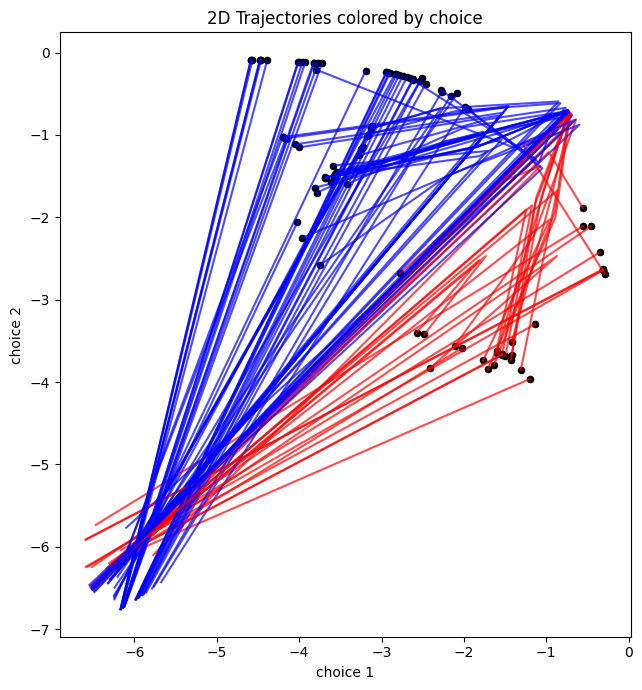

In [59]:
u, s, v = torch.svd(alpha.reshape(-1, 8))
# perform PCA on the h_segmented_actions
# h_pca = u[:, :3].reshape(200, 100, 4, 3).detach().cpu().numpy()
# h_pca = torch.log(alpha[..., [2, 6]]).reshape(200, 100, 4, 2).detach().cpu().numpy()
h_pca = torch.log(choices.reshape(200, 100, 4, 3).detach()).cpu().numpy()[..., 1:]
# h_pca = (alpha[..., [2, 6]]).reshape(200, 100, 4, 2).detach().cpu().numpy()
# Select a batch to plot
batch_idx = 0
# Get the top 3 principal components for the selected batch
pcs = h_pca[batch_idx, :, :, :3]  # shape: (n_subtrials, timesteps, 3)

# Prepare data for plotly: flatten sub-trials and timesteps
if len(pcs.shape) == 3: 
    n_subtrials, n_timesteps, _ = pcs.shape
else: 
    n_timesteps, _ = pcs.shape
    n_subtrials = 1

pcs_flat = pcs.reshape(-1, 2)
time_flat = np.tile(np.arange(n_timesteps), n_subtrials)

# Assign a color for each sub-trial
subtrial_ids = np.repeat(np.arange(n_subtrials), n_timesteps)

# fig = px.scatter_3d(
#     x=pcs_flat[:, 0],
#     y=pcs_flat[:, 1],
#     z=pcs_flat[:, 2],
#     color=time_flat * choice_pred[batch_idx].detach().cpu().repeat_interleave(n_timesteps).numpy(),  # color by time and choice
#     # animation_frame=subtrial_ids,
#     color_continuous_scale="RdBu", 
#     title="Top 3 PCs Trajectories (colored by time, animated by sub-trial)",
#     labels={'color': 'Time step'}
# )
# Plot 2D trajectories, coloring each subtrajectory segment by its corresponding choice
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(7, 7))
colors = plt.cm.RdBu(np.linspace(0, 1, n_subtrials))
# choice_pred = (alpha @ model.P) @ torch.tensor([[0, -1, 1]], device = alpha.device).sum(dim = -2).float()
choice_pred = (choices[..., 1] - choices[..., -1]).reshape(choices.shape[0], 100, 4).sum(dim = -1)

for i in range(n_subtrials):
    # Get the color for this subtrial based on choice_pred (should be -1 or 1)
    if hasattr(choice_pred, 'shape') and choice_pred.shape[0] > batch_idx:
        choice_val = choice_pred[batch_idx, i].detach().cpu().item() if choice_pred.ndim == 2 else choice_pred[batch_idx].detach().cpu().item()
    else:
        choice_val = 0
    color = 'red' if choice_val > 0 else 'blue'
    ax.plot(pcs[i, :, 0], pcs[i, :, 1], color=color, alpha=0.7)
    ax.scatter(pcs[i, 0, 0], pcs[i, 0, 1], color='black', marker='o', s=20)  # start point

ax.set_xlabel('choice 1')
ax.set_ylabel('choice 2')
ax.set_title('2D Trajectories colored by choice')
ax.set_aspect('equal')
plt.tight_layout()
# fig.update_traces(marker=dict(size=3))
# fig.update_layout(width=600, height=600)  # Make the figure square
# fig.show()
# fig.savefig(f'../../figures/discretised_rnn_2d_trajectories{"_pad_ones" if pad_ones else ""}.png', dpi=300)


In [53]:
import plotly.express as px
u, s, v = torch.svd(torch.log(alpha.reshape(-1, 8)))
h_pca = u[:, :3].reshape(200, 100, 4, 3).detach().cpu().numpy()

batch_idx = 1
# Get the top 3 principal components for the selected batch
pcs = h_pca[batch_idx, :, :, :3]  # shape: (n_subtrials, timesteps, 3)

# Prepare data for plotly: flatten sub-trials and timesteps
n_subtrials, n_timesteps, _ = pcs.shape
pcs_flat = pcs.reshape(-1, 3)
time_flat = np.tile(np.arange(n_timesteps), n_subtrials)

# Assign a color for each sub-trial
subtrial_ids = np.repeat(np.arange(n_subtrials), n_timesteps)

fig = px.scatter_3d(
    x=pcs_flat[:, 0],
    y=pcs_flat[:, 1],
    z=pcs_flat[:, 2],
    color=time_flat * choice_pred[batch_idx].detach().cpu().repeat_interleave(n_timesteps).numpy(),  # color by time and choice
    # animation_frame=subtrial_ids,
    color_continuous_scale="RdBu", 
    title="Top 3 PCs Trajectories (colored by time, animated by sub-trial)",
    labels={'color': 'Time step'}
)
fig.update_traces(marker=dict(size=2))
fig.show()

In [48]:
choice_pred.shape

torch.Size([200, 400])

In [97]:
import networkx as nx


In [91]:
stim_type[index, 4]

tensor(1, device='cuda:0')

In [32]:
model.save_checkpoint(MODEL_SAVE_PATH / "HMMModel_linearK" / "100_trials_dt05_8states.pth")

[autoreload of Network_models.HMMModels failed: Traceback (most recent call last):
  File "/home/timmy/miniconda3/envs/test/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/timmy/miniconda3/envs/test/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/timmy/miniconda3/envs/test/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/timmy/miniconda3/envs/test/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/timmy/miniconda3/envs/test/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/timmy/miniconda3/envs/test/lib/python3.12/site-packages

In [236]:
model.load_checkpoint(MODEL_SAVE_PATH / "HMMModel_linearK" / "100_trials_dt05_16states.pth")